<a href="https://colab.research.google.com/github/DeLucca990/Machine-Learning_Project/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final Machine Learning
### Integrantes:
- Pedro De Lucca
- Yan Romano
- Leornado Gomes

### Contextualização
Este projeto utiliza técnicas de aprendizado de máquina para construir um modelo capaz de analisar entradas visuais, como imagens, e prever em qual cargo profissional uma pessoa teria maior adequação. A proposta tem como objetivo explorar técnicas avançadas de processamento de imagens, aprendizado supervisionado e validação de modelos em um contexto de estudo.

**Nota Importante:** Este projeto foi desenvolvido exclusivamente para fins acadêmicos e de aprendizado, e não é apropriado para uso em aplicações práticas no mundo real. Reconhecemos que a utilização de algoritmos para análise de perfis profissionais a partir de imagens levanta questões éticas significativas, como privacidade, preconceitos implícitos nos dados, e a possibilidade de discriminação ou uso indevido da tecnologia.

### Objetivo:
- Treinar um modelo de machine learning para análise de imagens.
- Classificar os cargos com base em características extraídas das imagens fornecidas.

### Desafios:
- **Coleta de Dados**: Foi feito um scrapping de dados referentes ao LinkedIn, coletando imagens de perfis profissionais de pessoas com diferentes cargos.
- **Processamento**: Garantir que as imagens sejam normalizadas e preparadas adequadamente para o treinamento.
- **Modelagem**: Treinar um modelo de machine learning para classificar as imagens de acordo com os cargos.
- **Interpretação**: Interpretar os resultados do modelo e avaliar sua eficácia.

### Ambiente de Desenvolvimento
- **Google Colab**: Utilizamos o Google Colab para desenvolver o projeto, pois ele oferece um ambiente de desenvolvimento Jupyter Notebook com GPU gratuita.

Dentro do ambiente do Google Colab, clone o repositório do GitHub para acessar os arquivos necessários para o projeto.

In [40]:
!git clone https://github.com/DeLucca990/Machine-Learning_Project.git

fatal: destination path 'Machine-Learning_Project' already exists and is not an empty directory.


In [54]:
base_path = "/content/Machine-Learning_Project"

In [55]:
from PIL import Image
from pathlib import Path

def load_images():
    """
    Função para carregar as imagens do dataset
    """
    image_paths = list(Path(f'{base_path}/images').rglob('*.jpg'))
    images = []

    for image_path in image_paths:
        id = image_path.name.split('_')[1].split('.')[0]
        with Image.open(image_path) as img:
            img = img.resize((100, 100))
            images.append((int(id),img))
    return images

images = load_images()


In [56]:
import pandas as pd

# Carregar dados
dados = pd.read_excel(f'{base_path}/Tables/processed_tables/dados_limpos.xlsx')

In [57]:
# Juntar imagens com dados
# Estamos utilizando os dados referentes a indústria em que o usuário atua (Ex: 'Banking', 'Software', 'Retail', etc)

images_df = pd.DataFrame(images, columns=['id','image'])
df = dados.join(images_df.set_index('id'), on='id')
X = df['image']
y = df['industryName']

In [58]:
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')

[]

In [59]:
images_dict = dict(images)
df['imagem'] = df['id'].map(images_dict)

print(df.head())

   Unnamed: 0         id industryName  followersCount  experience  \
0           0   43695134      Banking            1476      2556.0   
1           1  154315745      Banking             666      4901.0   
2           2     643247      Banking             802      9039.0   
3           3  107217342      Banking             579      4690.0   
4           5  745012591      Banking             897      6666.0   

                                               image  \
0  <PIL.Image.Image image mode=RGB size=100x100 a...   
1  <PIL.Image.Image image mode=RGB size=100x100 a...   
2  <PIL.Image.Image image mode=RGB size=100x100 a...   
3  <PIL.Image.Image image mode=RGB size=100x100 a...   
4  <PIL.Image.Image image mode=RGB size=100x100 a...   

                                              imagem  
0  <PIL.Image.Image image mode=RGB size=100x100 a...  
1  <PIL.Image.Image image mode=RGB size=100x100 a...  
2  <PIL.Image.Image image mode=RGB size=100x100 a...  
3  <PIL.Image.Image image mo

In [60]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [61]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [62]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [63]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Input, Reshape

# Verifica se as entradas são imagens válidas e remove as linhas com entradas não-imagem
df = df[df['imagem'].apply(lambda img: isinstance(img, Image.Image))]

# Verificando e convertendo as imagens para o formato correto (numpy array)
def convert_images_to_array(df):
    images_array = []

    for img in df['imagem']:
        # Garantir que a imagem é válida e não é None
        if isinstance(img, Image.Image):
            # Converte a imagem para RGB se ela não for RGB
            img_resized = img.resize((100, 100))  # Redimensiona
            img_rgb = img_resized.convert('RGB')  # Força a conversão para RGB
            img_array = np.array(img_rgb)  # Converte para numpy array
            # Garantir que o array tenha 3 canais de cor (RGB)
            if img_array.shape == (100, 100, 3):
                images_array.append(img_array)
            else:
                print(f"Imagem com formato inesperado: {img_array.shape}")
        else:
            print(f"Imagem inválida ou não encontrada: {img}")

    # Converte a lista de arrays para um único array numpy
    return np.array(images_array)

# Chama a função para garantir que todas as imagens estão no formato correto
X = convert_images_to_array(df)

# Verificando o shape final de X
print(X.shape)

y = df['industryName']

# Separar os dados em treino e validação
X_train, X_valid, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)


(694, 100, 100, 3)


In [65]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.random.normal(tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

class LatentLossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        # Evitar NaNs usando clip_by_value para manter exp e log_var em faixa segura
        log_var = tf.clip_by_value(codings_log_var, -10.0, 10.0)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + log_var - tf.exp(log_var) - tf.square(codings_mean),
            axis=-1
        )
        # Adicionando a perda ao modelo
        self.add_loss(tf.reduce_mean(latent_loss) / 784.)
        return codings_mean

# Normalizar a entrada
X_train = X_train / 255.0
X_valid = X_valid / 255.0

# Parâmetros do modelo
codings_size = 40

# Encoder
inputs = tf.keras.layers.Input(shape=[100, 100, 3])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)
codings = Sampling()([codings_mean, codings_log_var])

# Camada de perda latente
codings_mean = LatentLossLayer()([codings_mean, codings_log_var])

# Construindo o modelo Encoder
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(100 * 100 * 3)(x)
outputs = tf.keras.layers.Reshape([100, 100, 3])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# Conectando Encoder e Decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# Compilando o modelo
variational_ae.compile(loss="mse", optimizer="nadam")

# Treinamento
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step - loss: 100428.9688 - val_loss: 1558.1665
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - loss: 571.1840 - val_loss: 2286.6724
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 323.6880 - val_loss: 631.3440
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 143.5770 - val_loss: 91.0819
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - loss: 34.2721 - val_loss: 26.1225
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - loss: 19.2378 - val_loss: 17.0756
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - loss: 12.7685 - val_loss: 11.3636
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 8.7176 - val_loss: 8.0281
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 5.7148 - val_loss: 5.5276
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 3.6375 - val_loss: 3.5853
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - loss: 2.4002 - val_loss: 2.4790
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Shape das imagens originais: (10, 100, 100, 3)
Shape das reconstruções após squeeze: (10, 100, 100, 3)


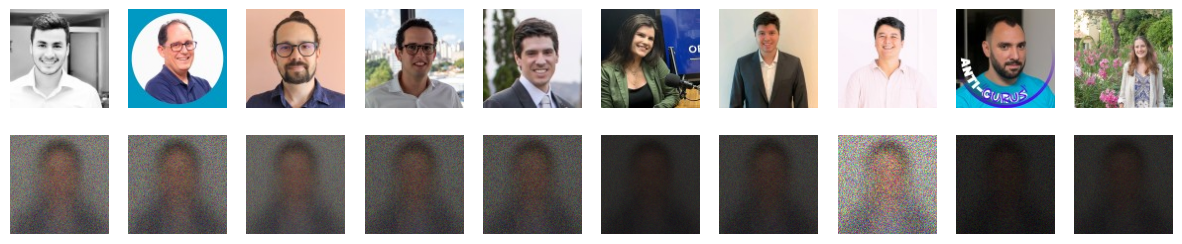

In [71]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, images, n_images=5):
    # Seleciona as primeiras n_images imagens e transforma em float32
    images = np.array(images[:n_images]).astype(np.float32)

    # Gera as reconstruções e converte para array
    reconstructions = np.array(model.predict(images)).astype(np.float32)

    # Remover a dimensão extra das reconstruções
    reconstructions = np.squeeze(reconstructions, axis=0)

    # Verifica as formas das imagens
    print(f"Shape das imagens originais: {images.shape}")
    print(f"Shape das reconstruções após squeeze: {reconstructions.shape}")

    # Normaliza ambas as imagens e reconstruções para o intervalo [0, 1]
    images = (images - images.min()) / (images.max() - images.min())
    reconstructions = (reconstructions - reconstructions.min()) / (reconstructions.max() - reconstructions.min())

    # Configura a visualização
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        # Exibe a imagem original
        plt.subplot(2, n_images, 1 + image_index)
        if images[image_index].ndim == 3:  # Se for RGB
            plt.imshow(images[image_index])
        else:  # Se for escala de cinza
            plt.imshow(images[image_index], cmap="gray")
        plt.axis("off")

        # Exibe a imagem reconstruída
        plt.subplot(2, n_images, 1 + n_images + image_index)
        if reconstructions[image_index].ndim == 3:  # Se for RGB
            plt.imshow(reconstructions[image_index])
        else:  # Se for escala de cinza
            plt.imshow(reconstructions[image_index], cmap="gray")
        plt.axis("off")

# Chama a função para exibir as reconstruções
plot_reconstructions(variational_ae, images=X_valid, n_images=10)
plt.show()